In [ ]:
import $file.scripts.importer

importer.loadProjectDependencies

In [ ]:
import scala.collection.JavaConverters._
import scala.collection.JavaConversions._
import edu.stanford.math.plex4._
import edu.stanford.math.plex4.api._
import edu.stanford.math.plex4.visualization._
import edu.stanford.math.plex4.homology.barcodes._

import breeze.numerics._
import breeze.linalg._
import breeze.math._
import breeze.stats.mean
import breeze.util.JavaArrayOps

import tda.persistence.Viz
import tda.persistence.Math

implicit def mapEntryAsTuple[T,S](me: java.util.Map.Entry[T,S]): (T,S) = {
  (me.getKey(), me.getValue)
}

def drawBarcodes(images: Seq[java.awt.image.BufferedImage]) = {
  images foreach publish.png 
}


In [ ]:
lazy val stream = Plex4.createExplicitSimplexStream()

stream.addVertex(0)
stream.addVertex(1)
stream.addVertex(2)
stream.addElement(Array(0, 1))
stream.addElement(Array(0, 2))
stream.addElement(Array(1,2))
stream.finalizeStream()

stream.getSize

In [ ]:
lazy val persistence = Plex4.getModularSimplicialAlgorithm(3, 2)
lazy val circleIntervals = persistence.computeIndexIntervals(stream)

## 9 - sphere 

In [ ]:
lazy val dimension = 9
lazy val stream = Plex4.createExplicitSimplexStream()
stream.addElement(0 to (dimension + 1) toArray)
stream.ensureAllFaces()
stream.removeElementIfPresent(0 to (dimension + 1) toArray)
stream.finalizeStream()

lazy val persistence9 = Plex4.getModularSimplicialAlgorithm(dimension + 1, 2)

In [ ]:
lazy val intervals9 = persistence.computeIntervals(stream)

# House

### Explicit stream

In [ ]:
lazy val houseStream = Plex4.createExplicitSimplexStream();
houseStream.addVertex(1, 0);
houseStream.addVertex(2, 0);
houseStream.addVertex(3, 0);
houseStream.addVertex(4, 0);
houseStream.addVertex(5, 1);
houseStream.addElement(Array(1, 2), 0);
houseStream.addElement(Array(2,3), 0);
houseStream.addElement(Array(3, 4), 0);
houseStream.addElement(Array(4, 1), 0);
houseStream.addElement(Array(3, 5), 2);
houseStream.addElement(Array(4, 5), 3);
houseStream.addElement(Array(3, 4, 5), 7);
houseStream.finalizeStream()

In [ ]:
lazy val intervals = persistence.computeIntervals(houseStream)
lazy val actualIntervals = intervals.getIntervalIterator.asScala.map(_.getValue).toList
actualIntervals.length

In [ ]:
lazy val intervalsDim0 = BarcodeUtility.getEndpoints(intervals, 1, false)

### Vietoris-Rips from point cloud

In [ ]:
lazy val pointCloud = examples.PointCloudExamples.getHouseExample()
lazy val houseMetricSpace= new metric.impl.EuclideanMetricSpace(pointCloud)

lazy val (maxDimension, maxFiltrationValue, numDivisions)= (3, 4.0, 100)

lazy val vietorisRipsStream = api.Plex4.createVietorisRipsStream(
  houseMetricSpace,
  maxDimension,
  maxFiltrationValue,
  numDivisions)

lazy val houseIntervals = persistence.computeIntervals(vietorisRipsStream)

lazy val houseImgs = Viz.barcodeImages(houseIntervals, maxFiltrationValue)

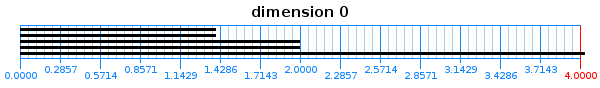

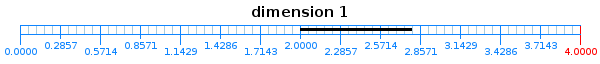

In [32]:
drawBarcodes(houseImgs)

## Torus homology 

In [ ]:
lazy val torusData = csvread(importer.loadData("pointsTorusGrid.csv"))

lazy val torusDataArray = JavaArrayOps.dmDToArray2(torusData)

lazy val (maxDimension, maxFiltrationValue, numDivisions) = (3, 0.9, 100)

lazy val torusStream = Plex4.createVietorisRipsStream(torusDataArray, maxDimension, maxFiltrationValue, numDivisions)

lazy val torusIntervals = persistence.computeIntervals(torusStream)

lazy val torusImages = Viz.barcodeImages(torusIntervals, maxFiltrationValue)

In [ ]:
println(Seq(
  "TorusStream for",
  s"maxFiltrationValue = ${maxFiltrationValue}",
  s"has ${torusStream.getSize()} simplices").mkString("\n"))

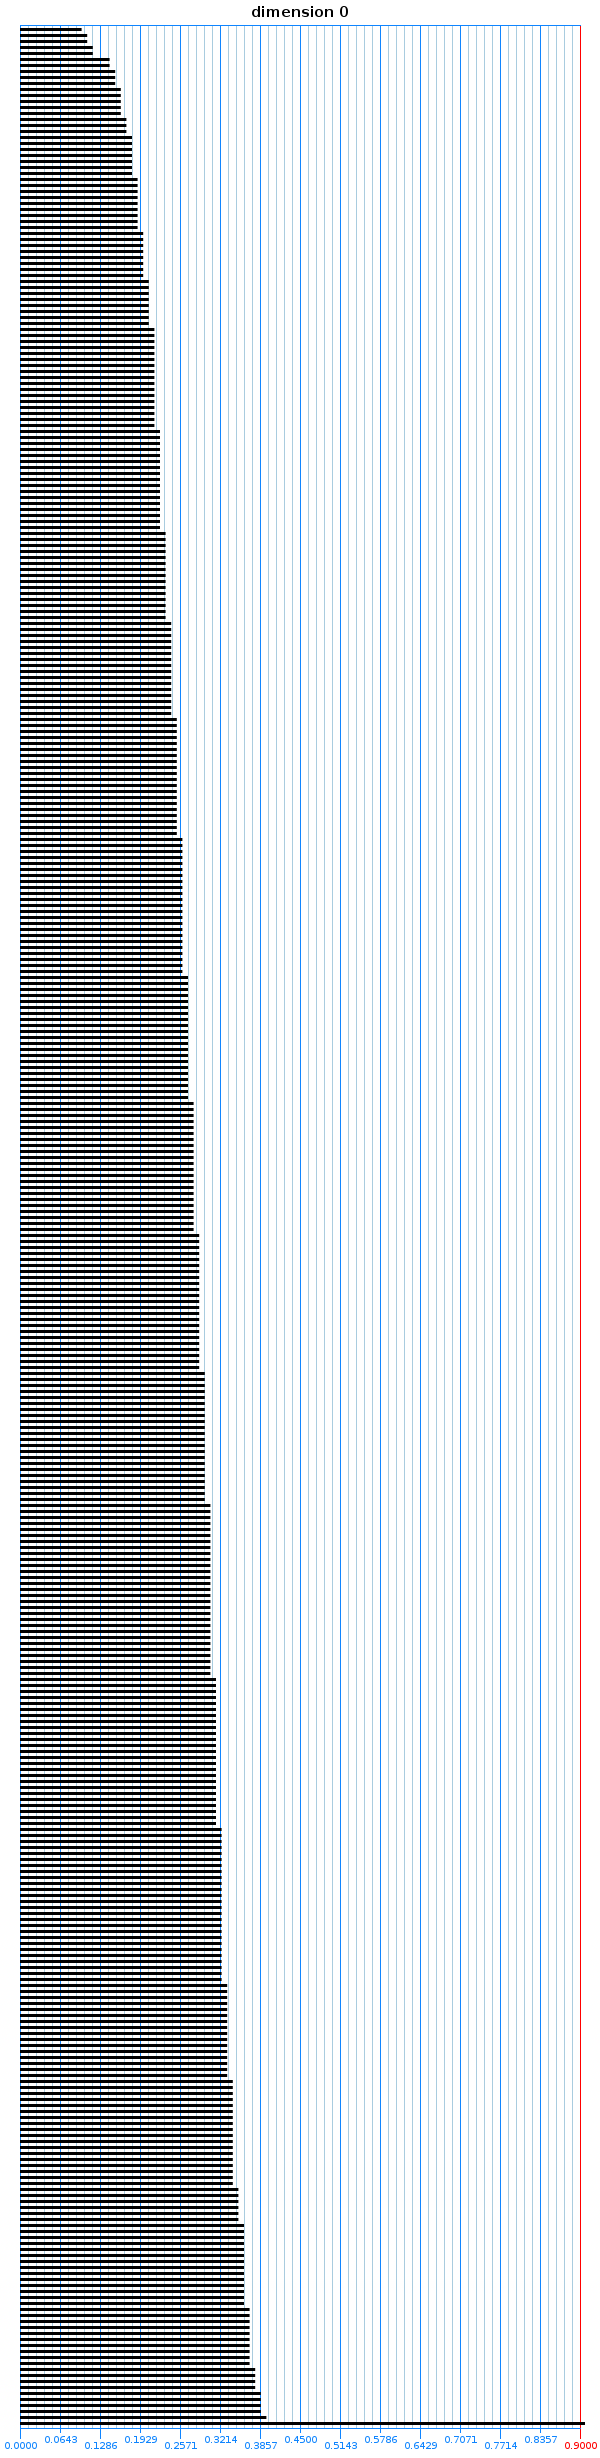

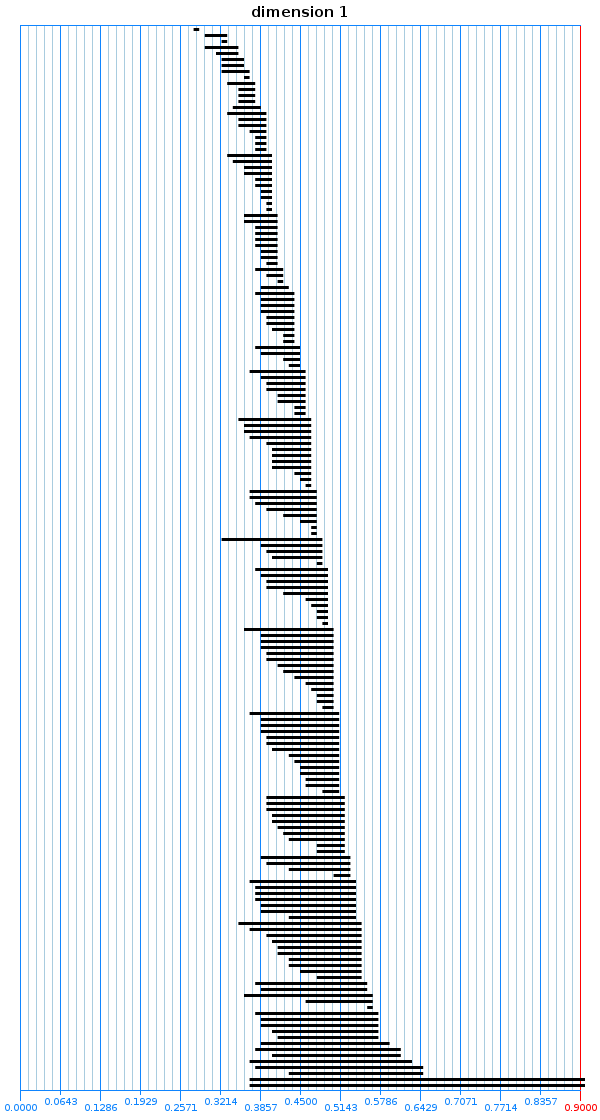

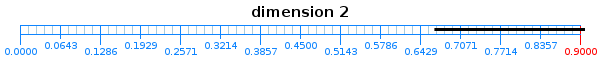

In [31]:
drawBarcodes(torusImages)

## Torus homology with witnesses

In [ ]:
lazy val noLandmarkPoints = 50 
lazy val witnessMaxFiltrationValue = 2* maxFiltrationValue

In [ ]:
lazy val landmarkIndices = Plex4
  .createMaxMinSelector(torusDataArray, noLandmarkPoints)
  .getLandmarkPoints()

lazy val torusWitnesses= landmarkIndices.map(torusDataArray(_))

lazy val torusWitnessStream = Plex4.createVietorisRipsStream(torusWitnesses, maxDimension, witnessMaxFiltrationValue, numDivisions)

lazy val torusWitnessIntervals = persistence.computeIntervals(torusWitnessStream)

lazy val torusWitnessImages = Viz.barcodeImages(torusWitnessIntervals, witnessMaxFiltrationValue)

In [ ]:
println(Seq(
  s"WitnessTorusStream for ${torusWitnesses.size} witnesses",
  s"witnessMaxFiltrationValue = ${witnessMaxFiltrationValue} = ${witnessMaxFiltrationValue / maxFiltrationValue} * maxFiltrationValue",
  s"has ${torusWitnessStream.getSize()} simplices",
  s"(${torusStream.getSize() / torusWitnessStream.getSize()}x less than original stream)").mkString("\n"))

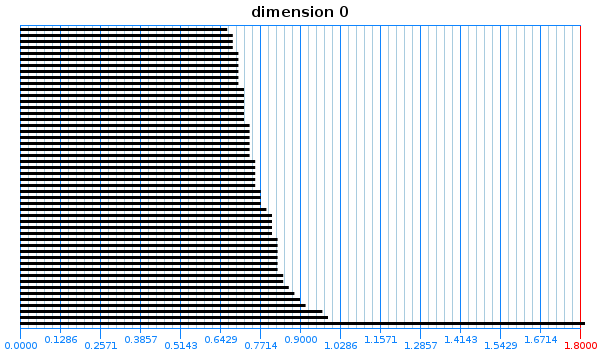

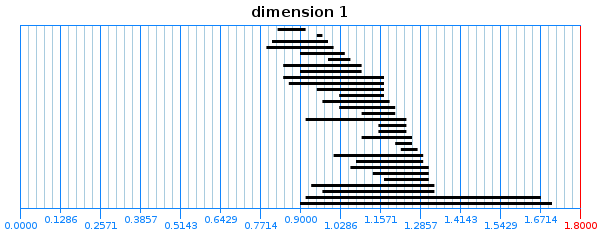

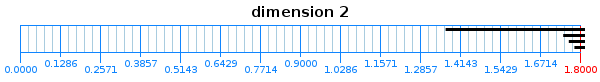

In [33]:
drawBarcodes(torusWitnessImages)

## Iris homology 

In [ ]:
lazy val irisAllData = csvread(importer.loadData("iris.csv"))

lazy val irisData = irisAllData(::, Range(0,4))
lazy val irisTarget = irisAllData(::, 4).map(_.toInt)
lazy val irisDataNormalized = irisAllData

lazy val irisDist = Math.dist(irisData, irisData)
lazy val irisArray = JavaArrayOps.dmDToArray2(irisAllData)

val irisMeanDist = mean(irisDist)
val irisMinDist = irisDist.toDenseVector.toArray

In [ ]:
lazy val (maxDimension, maxFiltrationValue, numDivisions) = (4, 0.66, 25)
lazy val irisStream = Plex4.createVietorisRipsStream(irisArray, maxDimension, maxFiltrationValue, numDivisions)

In [ ]:
println(Seq(
  "Iris Stream for",
  s"maxFiltrationValue = ${maxFiltrationValue}",
  s"has ${irisStream.getSize()} simplices").mkString("\n"))

In [ ]:
lazy val intervals = persistence.computeIntervals(irisStream)
lazy val imgs = Viz.barcodeImages(intervals, maxFiltrationValue)

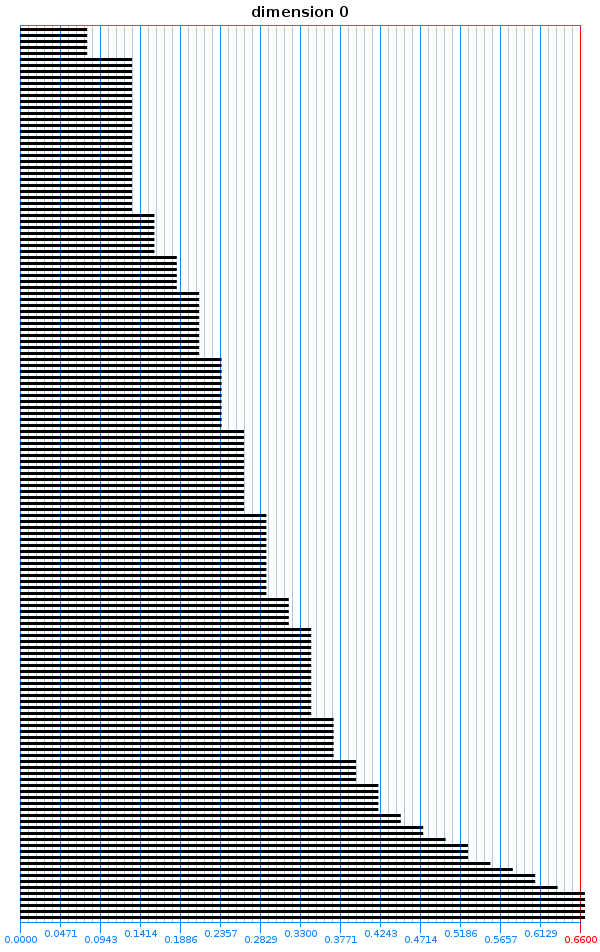

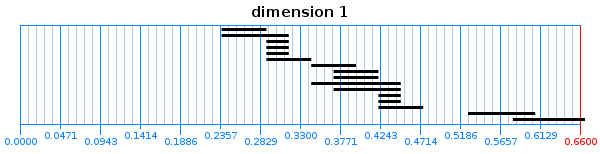

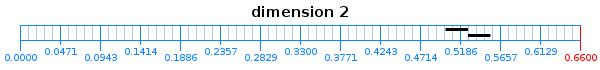

In [30]:
drawBarcodes(imgs)